In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
#dataset_path =  r"E:/edges2shoes"
dataset_path =  r"D:\scribbles\edges2shoes\edges2shoes"

In [3]:
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, features=64):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(features, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Initialize the discriminator and move it to the specified device
shoes_discriminator =UNetGenerator()
print("DCGAN Discriminator for Shoes initialized ")

DCGAN Discriminator for Shoes initialized 


In [4]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=6, features=64):
        super(PatchDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, edge, real):
        x = torch.cat([edge, real], dim=1)  # Concatenate (edge, real/generated)
        return self.model(x)

# Initialize Discriminator
discriminator = PatchDiscriminator()

print("Discriminator Model Created!")

Discriminator Model Created!


In [9]:
# Define the models
generator = UNetGenerator()
discriminator = PatchDiscriminator()

# Load the saved weights
checkpoint = torch.load("F:\generator_weights_Shoes.pth", map_location="cpu")
generator.load_state_dict(checkpoint, strict=False)
checkpoint = torch.load("F:\discriminator_weights_Shoes.pth", map_location="cpu")
discriminator.load_state_dict(checkpoint, strict=False)

# Set models to evaluation mode
generator.eval()
print(" Generator loaded ")
discriminator.eval()
print(" Discriminator loaded ")

 Generator loaded 
 Discriminator loaded 


In [73]:
class PairedImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Recursively find all images inside subfolders
        self.image_files = sorted(glob.glob(os.path.join(root, "**/*.jpg"), recursive=True))

        if len(self.image_files) == 0:
            raise RuntimeError(f"No images found in {root}. Check folder structure!")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))  # Skip to next image

        # Ensure images are split correctly (edges | real photo)
        w, h = img.size
        if w < 2:
            print(f"Skipping {img_path}, width too small!")
            return self.__getitem__((idx + 1) % len(self))

        edge = img.crop((0, 0, w // 2, h))  # Left half = Edge
        real = img.crop((w // 2, 0, w, h))  # Right half = Realistic photo

        if self.transform:
            edge = self.transform(edge)
            real = self.transform(real)

        return edge, real, img_path  # Return image path for reference

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for training
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize between -1 and 1
])

In [15]:
# Load dataset
dataset = PairedImageDataset(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Check a batch of data
for edge, real in dataloader:
    print("Edge batch shape:", edge.shape)
    print("Real batch shape:", real.shape)
    break

Edge batch shape: torch.Size([1, 3, 256, 256])
Real batch shape: torch.Size([1, 3, 256, 256])


# Project Real Images onto the Manifold

In [18]:
def project_image_to_manifold(generator, real_image, steps=100, lr=0.01):
    """
    Project a real image onto the learned manifold by optimizing the input edge map.
    """
    # Initialize a random edge map (same shape as the generator's input)
    edge_map = torch.randn_like(real_image, requires_grad=True)
    
    # Optimizer for the edge map
    optimizer = optim.Adam([edge_map], lr=lr)
    
    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()
        
        # Generate image from the edge map
        generated_image = generator(edge_map)
        
        # Compute reconstruction loss (L1 or L2)
        loss = torch.nn.functional.l1_loss(generated_image, real_image)
        
        # Backpropagate and update the edge map
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}")
    
    return edge_map

Step 0, Loss: 0.7830894589424133
Step 10, Loss: 0.6377098560333252
Step 20, Loss: 0.5334852933883667
Step 30, Loss: 0.458646684885025
Step 40, Loss: 0.39846479892730713
Step 50, Loss: 0.3443959653377533
Step 60, Loss: 0.29497623443603516
Step 70, Loss: 0.24997906386852264
Step 80, Loss: 0.20846541225910187
Step 90, Loss: 0.17226111888885498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8953292..3.0346549].


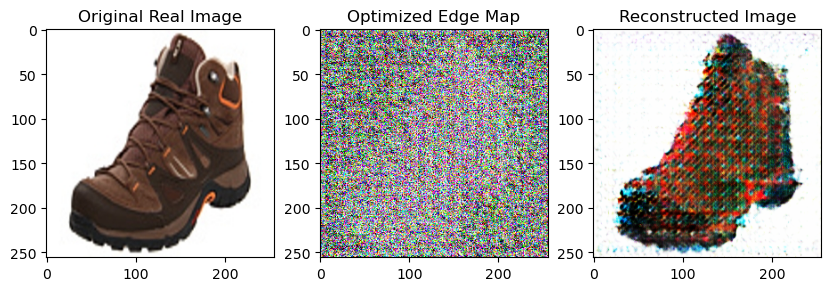

In [19]:
# Load a real image
real_image = next(iter(dataloader))[1]  # Real image from the dataset

# Project onto the manifold
optimized_edge_map = project_image_to_manifold(generator, real_image)

# Generate the reconstructed image
reconstructed_image = generator(optimized_edge_map)

# Visualize the results
plt.figure(figsize=(10, 5))

# Original Real Image
plt.subplot(1, 3, 1)
plt.title("Original Real Image")
plt.imshow(real_image.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)

# Optimized Edge Map
plt.subplot(1, 3, 2)
plt.title("Optimized Edge Map")
plt.imshow(optimized_edge_map.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)

# Reconstructed Image
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)

plt.show()

## Debug

In [21]:
print(real_image.shape)  # Expected: (1, 3, 256, 256)
print(optimized_edge_map.shape)  # Expected: (1, 3, 256, 256)
print(reconstructed_image.shape)  # Expected: (1, 3, 256, 256)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [23]:
print(real_image.min(), real_image.max())  # Expected: (-1, 1)

tensor(-1.) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7719657..2.8954968].


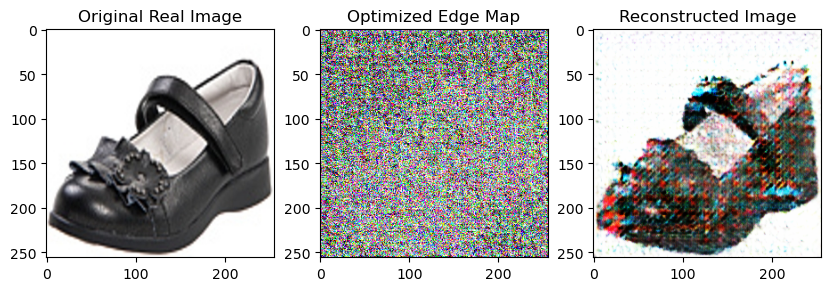

In [51]:
import matplotlib.pyplot as plt

# Visualize the original real image
plt.figure(figsize=(10, 5))

# Original Real Image
plt.subplot(1, 3, 1)
plt.title("Original Real Image")
plt.imshow(real_image.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)

# Optimized Edge Map
plt.subplot(1, 3, 2)
plt.title("Optimized Edge Map")
plt.imshow(optimized_edge_map.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5, cmap="gray")

# Reconstructed Image
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)

plt.show()

In [53]:
# Save the images
plt.savefig("output.png")  # Save the entire figure

# Or save individual images
from torchvision.utils import save_image

save_image(real_image * 0.5 + 0.5, "original_real_image.png")
save_image(optimized_edge_map * 0.5 + 0.5, "optimized_edge_map.png")
save_image(reconstructed_image * 0.5 + 0.5, "reconstructed_image.png")

<Figure size 640x480 with 0 Axes>

In [20]:
def tv_loss(img):
    """ Total Variation Loss to smooth the optimized edge image. """
    return torch.mean(torch.abs(img[:, :, :-1] - img[:, :, 1:])) + torch.mean(torch.abs(img[:, :-1, :] - img[:, 1:, :]))


In [22]:
def project_image_to_manifold(generator, real_image, edge_image, steps=500, lr=0.01, lambda_tv=0.05):
    """
    Project a real image onto the learned manifold by optimizing the input edge map.
    Uses TV loss to enforce smoothness.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Start from actual edge image instead of random noise
    edge_map = edge_image.clone().detach().to(device)
    edge_map.requires_grad = True

    optimizer = optim.Adam([edge_map], lr=lr)
    criterion = torch.nn.L1Loss()

    real_image = real_image.to(device)

    for step in range(steps):
        optimizer.zero_grad()
        
        #  Generate image from edge map
        generated_image = generator(edge_map)

        # Compute loss: Reconstruction + TV regularization
        loss = criterion(generated_image, real_image) + lambda_tv * tv_loss(edge_map)

        # Backpropagate and update the edge map
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

    print("Projection Complete!")
    return edge_map.detach()


In [24]:
# Load a batch from the dataset
edge_image, real_image = next(iter(dataloader))

# Move to device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
edge_image, real_image = edge_image.to(device), real_image.to(device)

# Print image shapes
print("Loaded Image Shapes:")
print("Edge Image Shape:", edge_image.shape)
print("Real Image Shape:", real_image.shape)


Loaded Image Shapes:
Edge Image Shape: torch.Size([1, 3, 256, 256])
Real Image Shape: torch.Size([1, 3, 256, 256])


In [26]:
# Run the projection function
optimized_edge_map = project_image_to_manifold(generator, real_image, edge_image, steps=500, lr=0.01, lambda_tv=0.05)

# Generate reconstructed image from optimized edge map
with torch.no_grad():
    reconstructed_image = generator(optimized_edge_map)


Step 0/500, Loss: 0.1972
Step 100/500, Loss: 0.0250
Step 200/500, Loss: 0.0222
Step 300/500, Loss: 0.0209
Step 400/500, Loss: 0.0203
Projection Complete!


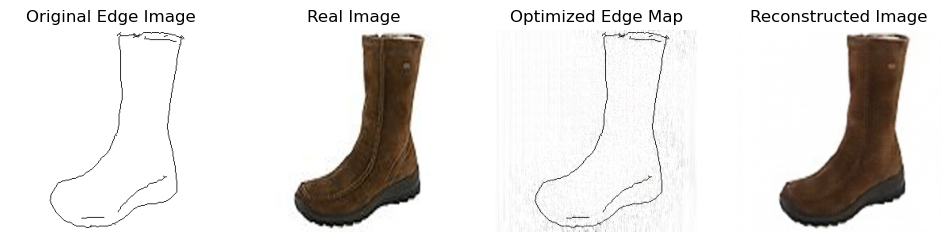

In [28]:
import matplotlib.pyplot as plt

def denormalize(img):
    """ Convert from [-1,1] to [0,1] for display """
    img = img * 0.5 + 0.5  # Scale to [0,1]
    return img.clamp(0, 1)  # Ensure valid range

# Convert tensors to display format
edge_image_disp = denormalize(edge_image[0]).permute(1, 2, 0).cpu().numpy()
real_image_disp = denormalize(real_image[0]).permute(1, 2, 0).cpu().numpy()
optimized_edge_disp = denormalize(optimized_edge_map[0]).permute(1, 2, 0).cpu().numpy()
reconstructed_disp = denormalize(reconstructed_image[0]).permute(1, 2, 0).cpu().numpy()

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(edge_image_disp, cmap="gray")
plt.title("Original Edge Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(real_image_disp)
plt.title("Real Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(optimized_edge_disp, cmap="gray")
plt.title("Optimized Edge Map")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(reconstructed_disp)
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()


## Interactive Drawing Interface

#### We'll create a UI for modifying the edge image using OpenCV.

In [30]:
# Load a batch from the dataset
edge_image, real_image = next(iter(dataloader))

# Move to device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
edge_image, real_image = edge_image.to(device), real_image.to(device)

# Ensure Edge Image is Properly Extracted
edge_image = edge_image[0].unsqueeze(0)  # Take first sample & ensure correct shape
real_image = real_image[0].unsqueeze(0)  # Take first real image

# Print shapes to verify
print(f"Edge Image Shape: {edge_image.shape}")
print(f"Real Image Shape: {real_image.shape}")


Edge Image Shape: torch.Size([1, 3, 256, 256])
Real Image Shape: torch.Size([1, 3, 256, 256])


## Define the Mouse Callback for Drawing

In [33]:
import cv2
import numpy as np
import torch

# Initialize global variables
drawing = False
ix, iy = -1, -1
color = (0, 0, 255)  # Red brush for visibility

def draw(event, x, y, flags, param):
    """ Mouse callback function to draw on the edge image. """
    global ix, iy, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(param, (x, y), 3, color, -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(param, (x, y), 3, color, -1)


## Modify Edge Image with UI

In [36]:
def modify_edge_map(edge_image):
    """ Allows the user to interactively modify the edge image. """
    edge_np = edge_image.squeeze().cpu().numpy()  # Ensure it's 2D (H, W)
    edge_np = np.clip(edge_np, 0, 1)  # Ensure values are within [0, 1]
    edge_np = (edge_np * 255).astype(np.uint8)   # Convert to [0, 255] range

    #  Ensure image has a single channel
    if len(edge_np.shape) == 3:
        edge_np = edge_np[0]  # Take first channel if extra dimensions exist
    
    #  Convert to 3-channel for OpenCV display
    edge_np = cv2.cvtColor(edge_np, cv2.COLOR_GRAY2BGR)

    cv2.namedWindow("Modify Edge Map")
    cv2.setMouseCallback("Modify Edge Map", draw, edge_np)

    while True:
        cv2.imshow("Modify Edge Map", edge_np)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):  # Press 'q' to exit
            break

    cv2.destroyAllWindows()
    
    # Convert back to tensor
    edge_modified = torch.tensor(edge_np[:, :, 0] / 255.0).unsqueeze(0).unsqueeze(0)
    return edge_modified



## Run Edge Modification

In [40]:
def smooth_edge_map(edge_map, kernel_size=5):
    edge_np = edge_map.squeeze().cpu().numpy()  # Convert to NumPy
    edge_np = cv2.GaussianBlur(edge_np, (kernel_size, kernel_size), 0)  # Apply blur
    return torch.tensor(edge_np).unsqueeze(0).unsqueeze(0).to(edge_map.device)  # Convert back to tensor

edge_modified = smooth_edge_map(edge_modified)  # Apply smoothing


In [42]:
# Modify the Edge Map (User Interaction)
edge_modified = modify_edge_map(optimized_edge_map)  # User edits the edge map

# Apply Smoothing Before Feeding to Generator 
edge_modified = smooth_edge_map(edge_modified)  # Smooth the edges

# Ensure edge_modified has 3 channels (Duplicate the 1-channel input)
edge_modified = edge_modified.expand(-1, 3, -1, -1)  # Expands to match generator input

# Convert to float32 & Move to Correct Device
edge_modified = edge_modified.to(torch.float32).to(device)

# Generate new image from modified edge map
with torch.no_grad():
    generated_image = generator(edge_modified)
    
# Convert for visualization
edge_modified_disp = edge_modified.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_image_disp = (generated_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5

## Generate New Image from the Modified Edge Map

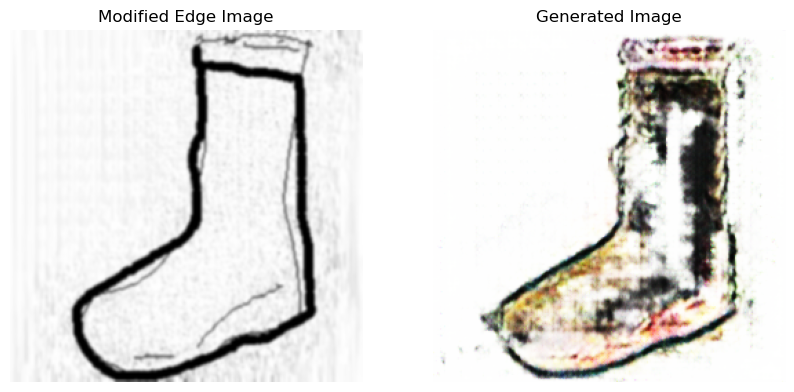

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(edge_modified_disp, cmap="gray")
plt.title("Modified Edge Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(generated_image_disp)
plt.title("Generated Image")
plt.axis("off")

plt.show()


In [60]:
from torchvision.utils import save_image

# Save the Modified Edge Image
save_image(edge_modified * 0.5 + 0.5, "modified_edge_image_gboot.png")

# Save the Generated Image
save_image(generated_image * 0.5 + 0.5, "generated_image_gboot.png")

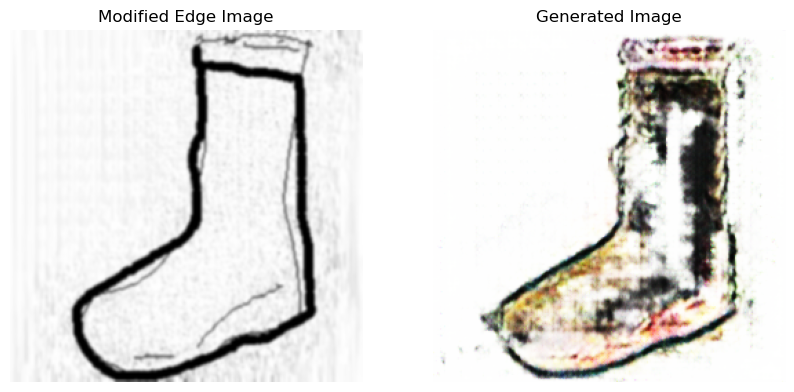

In [48]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(10, 5))

# Modified Edge Image
plt.subplot(1, 2, 1)
plt.imshow(edge_modified_disp, cmap="gray")
plt.title("Modified Edge Image")
plt.axis("off")

# Generated Image
plt.subplot(1, 2, 2)
plt.imshow(generated_image_disp)
plt.title("Generated Image")
plt.axis("off")

plt.show()

In [47]:
print(edge_modified.shape)  # Expected: (1, 3, 256, 256)
print(generated_image.shape)  # Expected: (1, 3, 256, 256)

torch.Size([1, 1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [49]:
print(edge_modified.min(), edge_modified.max())  # Expected: (-1, 1)
print(generated_image.min(), generated_image.max())  # Expected: (-1, 1)

tensor(0.) tensor(1.0000)
tensor(-0.9768) tensor(1.)


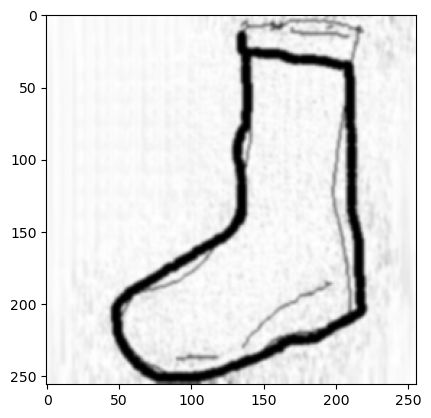

In [62]:
plt.imshow(edge_modified_disp, cmap="gray")
plt.show()

In [53]:
# Normalize the generated image to [0, 1]
generated_image_normalized = (generated_image + 1) / 2

In [55]:
import matplotlib.pyplot as plt

# Convert tensors to display format
edge_modified_disp = edge_modified.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_image_disp = generated_image_normalized.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot results
plt.figure(figsize=(10, 5))

# Modified Edge Image
plt.subplot(1, 2, 1)
plt.imshow(edge_modified_disp, cmap="gray")
plt.title("Modified Edge Image")
plt.axis("off")

# Generated Image
plt.subplot(1, 2, 2)
plt.imshow(generated_image_disp)
plt.title("Generated Image")
plt.axis("off")

plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [78]:
print(edge_modified.min(), edge_modified.max())  # Expected: (0, 1)
print(generated_image_normalized.min(), generated_image_normalized.max())  # Expected: (0, 1)

tensor(0.) tensor(1.)
tensor(0.0082) tensor(1.)


In [50]:
# Cell 1: Install required libraries
!pip install lpips torchmetrics scikit-image

DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\apache_beam-2.60.0-py3.11-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\avro_python3-1.10.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\contextlib2-21.6.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\lvis-0.5.3-py3.11.egg is d

In [54]:
!pip install lpips==0.1.4 torchmetrics==0.11.4 scikit-image torch-fidelity
!pip install --upgrade torchvision

  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.7.0
    Uninstalling torchmetrics-1.7.0:
      Successfully uninstalled torchmetrics-1.7.0


DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\apache_beam-2.60.0-py3.11-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\avro_python3-1.10.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\contextlib2-21.6.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\lvis-0.5.3-py3.11.egg is d

  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl (1.6 MB)
Using cached torch-2.6.0-cp311-cp311-win_amd64.whl (204.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.0
    Uninstalling torchvision-0.17.0:
      Successfully uninstalled torchvision-0.17.0


DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\apache_beam-2.60.0-py3.11-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\avro_python3-1.10.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\contextlib2-21.6.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\shashwati\anaconda3\lib\site-packages\lvis-0.5.3-py3.11.egg is d

In [55]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Safe LPIPS import
try:
    import lpips
    loss_fn_lpips = lpips.LPIPS(net='vgg').eval()
    print("LPIPS initialized successfully")
except Exception as e:
    print(f"LPIPS initialization failed: {e}")
    loss_fn_lpips = None

# Safe FID import
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    fid = FrechetInceptionDistance(feature=2048)
    print("FID initialized successfully")
except Exception as e:
    print(f"FID initialization failed: {e}")
    fid = None

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\SHASHWATI\anaconda3\Lib\site-packages\lpips\weights\v0.1\vgg.pth
LPIPS initialized successfully
FID initialization failed: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.


In [58]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import lpips

# Initialize LPIPS
loss_fn_lpips = lpips.LPIPS(net='vgg').eval()
print("LPIPS ready")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\SHASHWATI\anaconda3\Lib\site-packages\lpips\weights\v0.1\vgg.pth
LPIPS ready


In [68]:
# Assuming batch_size=1 for simplicity
edge_image, real_image = next(iter(dataloader))

# Move tensors to device
device = "cuda" if torch.cuda.is_available() else "cpu"
edge_image, real_image = edge_image.to(device), real_image.to(device)

print("Loaded Image Shapes:")
print("Edge Image Shape:", edge_image.shape)
print("Real Image Shape:", real_image.shape)

# Print real image path
print("Real Image Path:", real_image[0])


Loaded Image Shapes:
Edge Image Shape: torch.Size([1, 3, 256, 256])
Real Image Shape: torch.Size([1, 3, 256, 256])
Real Image Path: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [81]:
def __getitem__(self, idx):
    img_path = self.image_files[idx]

    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return self.__getitem__((idx + 1) % len(self))  # Skip to next image

    w, h = img.size
    if w < 2:
        print(f"Skipping {img_path}, width too small!")
        return self.__getitem__((idx + 1) % len(self))

    edge = img.crop((0, 0, w//2, h))
    real = img.crop((w//2, 0, w, h))

    if self.transform:
        edge = self.transform(edge)
        real = self.transform(real)

    return edge, real, img_path  # ✅ Now returning 3 values


In [83]:
# Load a batch from the dataset
edge_image, real_image, img_path = next(iter(dataloader))

print("Edge shape:", edge_image.shape)
print("Real shape:", real_image.shape)
print("File path:", img_path)


ValueError: not enough values to unpack (expected 3, got 2)

In [64]:
def load_image_as_tensor(path):
    img = Image.open(path).convert('RGB')
    return torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

# Load images (replace with your paths)
real_image_path = 'real_shoe.png'  # Same path used in your visualization
gt_img = load_image_as_tensor(real_image_path)
gen_img = load_image_as_tensor('generated_image_gboot.png')


FileNotFoundError: [Errno 2] No such file or directory: 'real_shoe.png'

In [87]:
# First, let's modify your dataset class to keep track of image paths
class PairedImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = sorted(glob.glob(os.path.join(root, "**/*.jpg"), recursive=True))
        
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        edge = img.crop((0, 0, w//2, h))  # Left half
        real = img.crop((w//2, 0, w, h))  # Right half
        
        if self.transform:
            edge = self.transform(edge)
            real = self.transform(real)
            
        return edge, real, img_path  # Now returning path too

# Update transformations to handle evaluation
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Create evaluation dataset
eval_dataset = PairedImageDataset(root=dataset_path, transform=eval_transform)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [89]:
def evaluate_pair(generator, edge, real, device='cuda'):
    """Quantitatively compare generated and real images"""
    # Move to device
    edge = edge.to(device)
    real = real.to(device)
    
    # Generate image
    with torch.no_grad():
        generated = generator(edge)
    
    # Convert to [0,1] range
    real = (real + 1) / 2
    generated = (generated + 1) / 2
    
    # Calculate metrics
    ssim_score = ssim(
        real[0].permute(1,2,0).cpu().numpy(),
        generated[0].permute(1,2,0).cpu().numpy(),
        multichannel=True,
        data_range=1.0
    )
    
    # Calculate LPIPS (perceptual similarity)
    lpips_score = loss_fn_lpips(real*2-1, generated*2-1)  # Scale to [-1,1]
    
    return {
        'ssim': ssim_score,
        'lpips': lpips_score.item(),
        'generated': generated,
        'real': real
    }

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\SHASHWATI\anaconda3\Lib\site-packages\lpips\weights\v0.1\vgg.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


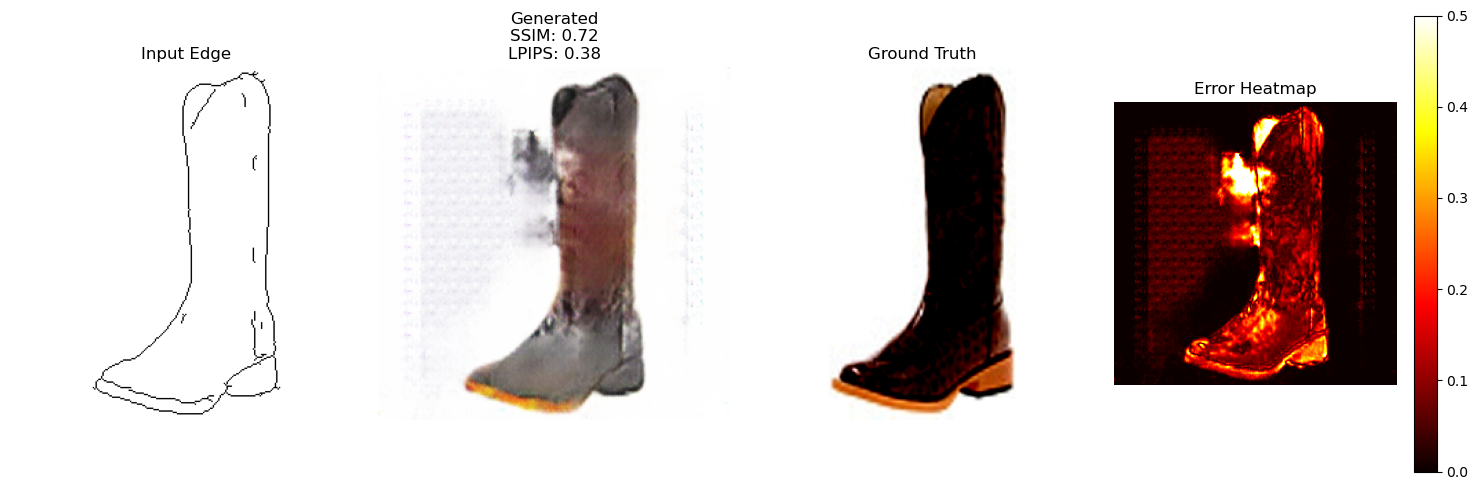

In [93]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import lpips

# Initialize LPIPS
loss_fn_lpips = lpips.LPIPS(net='vgg').eval()

def evaluate_generation(generator, edge_tensor, real_tensor):
    """Quantify generation quality against ground truth"""
    device = next(generator.parameters()).device

    with torch.no_grad():
        generated = generator(edge_tensor.to(device))

    # Convert to numpy arrays in [0,1] range
    real = (real_tensor.squeeze().permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    gen = (generated.squeeze().permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)

    # Calculate SSIM
    ssim_score = ssim(real, gen, channel_axis=2, data_range=1.0)

    # Calculate LPIPS (requires [-1,1] range)
    lpips_score = loss_fn_lpips(real_tensor.to(device), generated).item()

    # Pixel-wise absolute error
    error_map = np.abs(real - gen).mean(axis=2)

    return {
        'ssim': ssim_score,
        'lpips': lpips_score,
        'error_map': error_map,
        'generated': gen
    }

# Example usage (make sure `dataloader` and `generator` are defined and on the correct device)
edge, real = next(iter(dataloader))

# Evaluate
metrics = evaluate_generation(generator, edge, real)

# Visualize results
plt.figure(figsize=(15, 5))

# Input Edge
plt.subplot(1, 4, 1)
plt.imshow(edge[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Input Edge")
plt.axis('off')

# Generated Image
plt.subplot(1, 4, 2)
plt.imshow(metrics['generated'])
plt.title(f"Generated\nSSIM: {metrics['ssim']:.2f}\nLPIPS: {metrics['lpips']:.2f}")
plt.axis('off')

# Ground Truth
plt.subplot(1, 4, 3)
plt.imshow(real[0].permute(1, 2, 0).cpu().numpy())
plt.title("Ground Truth")
plt.axis('off')

# Error Heatmap
plt.subplot(1, 4, 4)
plt.imshow(metrics['error_map'], cmap='hot', vmin=0, vmax=0.5)
plt.title("Error Heatmap")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


Step 0/500, Loss: 0.1240
Step 100/500, Loss: 0.0342
Step 200/500, Loss: 0.0295
Step 300/500, Loss: 0.0276
Step 400/500, Loss: 0.0264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21069425..1.3325119].


Projection Complete!


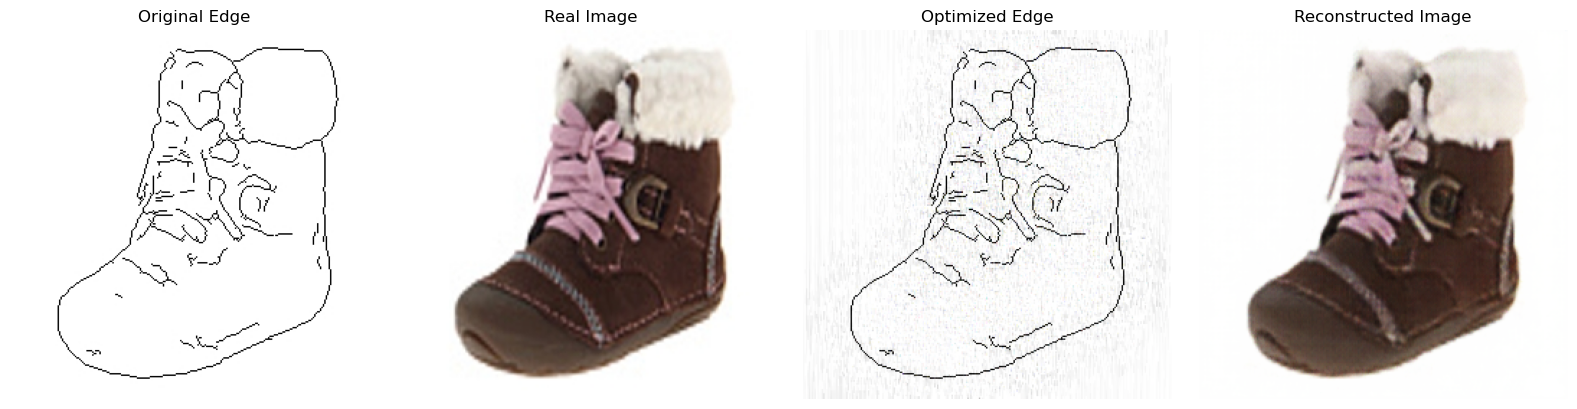

In [95]:
# Get a batch from dataloader
edge, real = next(iter(dataloader))
edge, real = edge.to(device), real.to(device)

# Project to manifold
optimized_edge = project_image_to_manifold(generator, real, edge, steps=500, lr=0.01, lambda_tv=0.05)

# Generate reconstructed image
with torch.no_grad():
    reconstructed = generator(optimized_edge)

# Convert to display format
def tensor_to_display(tensor):
    return tensor.squeeze(0).permute(1,2,0).cpu().numpy() * 0.5 + 0.5

# Plot
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(tensor_to_display(edge), cmap='gray')
plt.title("Original Edge")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(tensor_to_display(real))
plt.title("Real Image")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(tensor_to_display(optimized_edge), cmap='gray')
plt.title("Optimized Edge")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(tensor_to_display(reconstructed))
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [97]:
# Modify edge through UI (simulated here with random strokes)
modified_edge = optimized_edge.clone()
modified_edge[:,:,:50,:50] = 1  # Simulate user drawing in top-left corner

# Smooth modifications
modified_edge = smooth_edge_map(modified_edge)

# Generate from modified edge
with torch.no_grad():
    generated = generator(modified_edge)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(tensor_to_display(modified_edge), cmap='gray')
plt.title("Modified Edge")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(tensor_to_display(generated))
plt.title("Generated Image")
plt.axis('off')

plt.tight_layout()
plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 256, 256]

In [ ]:
# Calculate error
error = torch.abs(real - generated).mean(dim=1, keepdim=True)

# Plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(tensor_to_display(real))
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(tensor_to_display(generated))
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(error.squeeze().cpu().numpy(), cmap='hot', vmin=0, vmax=0.5)
plt.title("Error Heatmap")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics
ssim_score = ssim(
    tensor_to_display(real), 
    tensor_to_display(generated),
    channel_axis=2,
    data_range=1.0
)
print(f"SSIM: {ssim_score:.3f} (1.0 = perfect)")
print(f"Mean Error: {error.mean().item():.3f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\SHASHWATI\anaconda3\Lib\site-packages\lpips\weights\v0.1\alex.pth
FID calculation failed: Non-matrix input to matrix function.

Model Performance Metrics:
PSNR: 17.57 dB (higher is better)
SSIM: 0.7589 (closer to 1 is better)
LPIPS: 0.3545 (closer to 0 is better)
FID: nan (lower is better, NaN if computation failed)


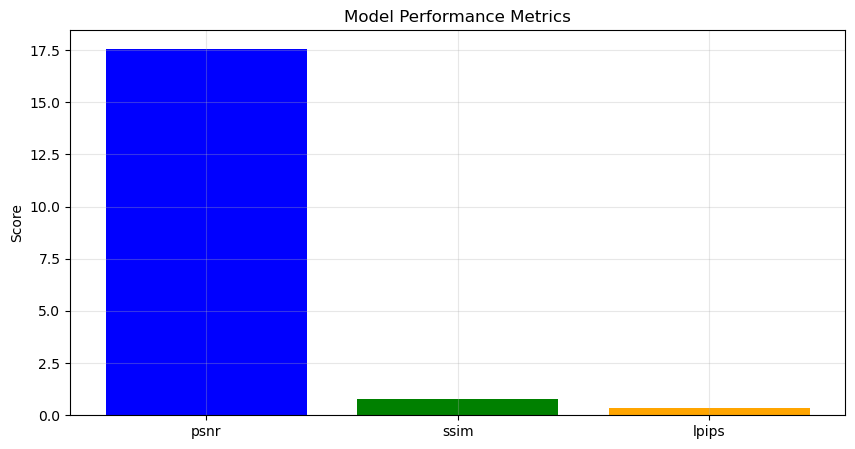

In [103]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy import linalg
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from lpips import LPIPS

# Initialize LPIPS model (for perceptual similarity)
lpips_model = LPIPS(net='alex').to(device)

# Function to calculate PSNR
def calculate_psnr(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0,1]
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1)
    return psnr(real_img.cpu().numpy(), gen_img.cpu().numpy(), data_range=1.0)

# Function to calculate SSIM with proper shape handling
def calculate_ssim(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1)
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1)
    
    # Convert to numpy and handle batch and channel dimensions
    real_np = real_img.squeeze().permute(1, 2, 0).cpu().numpy()  # [H,W,C]
    gen_np = gen_img.squeeze().permute(1, 2, 0).cpu().numpy()    # [H,W,C]
    
    # Calculate SSIM for each channel and average
    ssims = []
    for i in range(real_np.shape[-1]):
        ssims.append(ssim(real_np[..., i], gen_np[..., i], 
                       data_range=1.0, win_size=3))
    return np.mean(ssims)

# Function to calculate LPIPS
def calculate_lpips(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1) * 2 - 1  # Scale to [-1,1] for LPIPS
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1) * 2 - 1
    return lpips_model(real_img, gen_img).item()

# Function to calculate FID (with robust covariance handling)
def calculate_fid(real_imgs, gen_imgs):
    # Load pre-trained Inception-v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    # Extract features (use the pool3 layer)
    def get_features(imgs):
        imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear')
        with torch.no_grad():
            features = inception_model(imgs)[0]  # Get pool3 features
        return features.squeeze().cpu().numpy()
    
    # Get features for real and generated images
    real_features = get_features(real_imgs)
    gen_features = get_features(gen_imgs)
    
    # Ensure features are 2D [num_samples, feature_dim]
    if real_features.ndim == 1:
        real_features = np.expand_dims(real_features, 0)
    if gen_features.ndim == 1:
        gen_features = np.expand_dims(gen_features, 0)
    
    # Calculate mean and covariance
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
    
    # Calculate FID
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)  # Handle sqrtm safely
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Collect metrics for multiple samples
def evaluate_model(generator, dataloader, num_samples=10):
    psnr_values = []
    ssim_values = []
    lpips_values = []
    real_images = []
    gen_images = []
    
    with torch.no_grad():
        for i, (edge, real) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            edge, real = edge.to(device), real.to(device)
            generated = generator(edge)
            
            # Calculate metrics
            psnr_values.append(calculate_psnr(real, generated))
            ssim_values.append(calculate_ssim(real, generated))
            lpips_values.append(calculate_lpips(real, generated))
            
            # Store images for FID
            real_images.append(real)
            gen_images.append(generated)
    
    # Convert lists to tensors
    real_images = torch.cat(real_images, dim=0)
    gen_images = torch.cat(gen_images, dim=0)
    
    # Calculate FID (skip if too few samples)
    fid_score = np.nan  # Default if FID fails
    if len(real_images) >= 2:  # Minimum 2 samples for covariance
        try:
            fid_score = calculate_fid(real_images, gen_images)
        except Exception as e:
            print(f"FID calculation failed: {e}")
    
    return {
        'psnr': np.mean(psnr_values),
        'ssim': np.mean(ssim_values),
        'lpips': np.mean(lpips_values),
        'fid': fid_score
    }

# Evaluate the model
metrics = evaluate_model(generator, dataloader, num_samples=min(10, len(dataloader)))
print("\nModel Performance Metrics:")
print(f"PSNR: {metrics['psnr']:.2f} dB (higher is better)")
print(f"SSIM: {metrics['ssim']:.4f} (closer to 1 is better)")
print(f"LPIPS: {metrics['lpips']:.4f} (closer to 0 is better)")
print(f"FID: {metrics['fid']:.2f} (lower is better, NaN if computation failed)")

# Visualize metrics (skip FID if NaN)
valid_metrics = {k: v for k, v in metrics.items() if not np.isnan(v)}
plt.figure(figsize=(10, 5))
plt.bar(valid_metrics.keys(), valid_metrics.values(),
        color=['blue', 'green', 'orange', 'red'][:len(valid_metrics)])
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

In [105]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg

# Initialize Inception-v3 for FID (use pool3 features)
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

def get_features(imgs):
    """Extract features from Inception-v3's pool3 layer"""
    imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear')
    with torch.no_grad():
        features = inception_model(imgs)[0]  # Get pool3 features
    return features.cpu().numpy()

def calculate_fid(real_imgs, gen_imgs):
    """Robust FID calculation with shape checks"""
    # Extract features
    real_features = get_features(real_imgs)
    gen_features = get_features(gen_imgs)
    
    # Ensure features are 2D [num_samples, feature_dim]
    if real_features.ndim == 1:
        real_features = np.expand_dims(real_features, 0)
    if gen_features.ndim == 1:
        gen_features = np.expand_dims(gen_features, 0)
    
    # Calculate statistics
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
    
    # Safely compute sqrt of matrix product
    covmean = linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID
    diff = mu1 - mu2
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Evaluate with checks
def evaluate_model(generator, dataloader, num_samples=10):
    # ... (keep PSNR/SSIM/LPIPS code from previous example) ...
    
    # Only compute FID if we have enough samples
    fid_score = np.nan
    if len(real_images) >= 2:  # Minimum 2 samples for covariance
        try:
            fid_score = calculate_fid(real_images, gen_images)
        except Exception as e:
            print(f"FID failed (likely numerical instability): {str(e)}")
    
    return {
        'psnr': np.mean(psnr_values),
        'ssim': np.mean(ssim_values),
        'lpips': np.mean(lpips_values),
        'fid': fid_score if not np.isnan(fid_score) else None
    }

In [109]:
# Collect metrics for multiple samples
def evaluate_model(generator, dataloader, num_samples=10):
    psnr_values = []
    ssim_values = []
    lpips_values = []
    real_images = []
    gen_images = []
    
    with torch.no_grad():
        for i, (edge, real) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            edge, real = edge.to(device), real.to(device)
            generated = generator(edge)
            
            # Calculate metrics
            psnr_values.append(calculate_psnr(real, generated))
            ssim_values.append(calculate_ssim(real, generated))
            lpips_values.append(calculate_lpips(real, generated))
            
            # Store images for FID
            real_images.append(real)
            gen_images.append(generated)
    
    # Convert lists to tensors
    real_images = torch.cat(real_images, dim=0)
    gen_images = torch.cat(gen_images, dim=0)
    
    # Calculate FID (skip if too few samples)
    fid_score = np.nan  # Default if FID fails
    if len(real_images) >= 2:  # Minimum 2 samples for covariance
        try:
            fid_score = calculate_fid(real_images, gen_images)
        except Exception as e:
            print(f"FID calculation failed: {e}")
    
    return {
        'psnr': np.mean(psnr_values),
        'ssim': np.mean(ssim_values),
        'lpips': np.mean(lpips_values),
        'fid': fid_score
    }

FID calculation failed: Non-matrix input to matrix function.

Model Performance Metrics:
PSNR: 17.60 dB (higher is better)
SSIM: 0.7269 (closer to 1 is better)
LPIPS: 0.3030 (closer to 0 is better)
FID: nan (lower is better, NaN if computation failed)


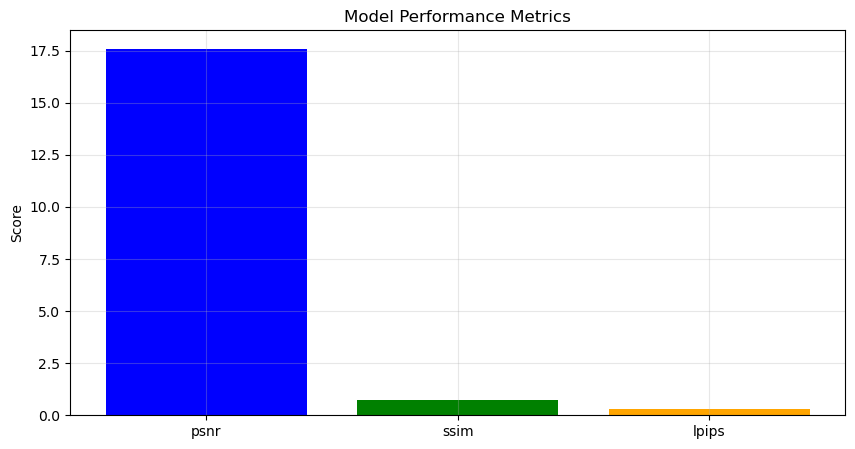

In [111]:
# Evaluate the model
metrics = evaluate_model(generator, dataloader, num_samples=min(10, len(dataloader)))
print("\nModel Performance Metrics:")
print(f"PSNR: {metrics['psnr']:.2f} dB (higher is better)")
print(f"SSIM: {metrics['ssim']:.4f} (closer to 1 is better)")
print(f"LPIPS: {metrics['lpips']:.4f} (closer to 0 is better)")
print(f"FID: {metrics['fid']:.2f} (lower is better, NaN if computation failed)")

# Visualize metrics (skip FID if NaN)
valid_metrics = {k: v for k, v in metrics.items() if not np.isnan(v)}
plt.figure(figsize=(10, 5))
plt.bar(valid_metrics.keys(), valid_metrics.values(),
        color=['blue', 'green', 'orange', 'red'][:len(valid_metrics)])
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\SHASHWATI\anaconda3\Lib\site-packages\lpips\weights\v0.1\alex.pth


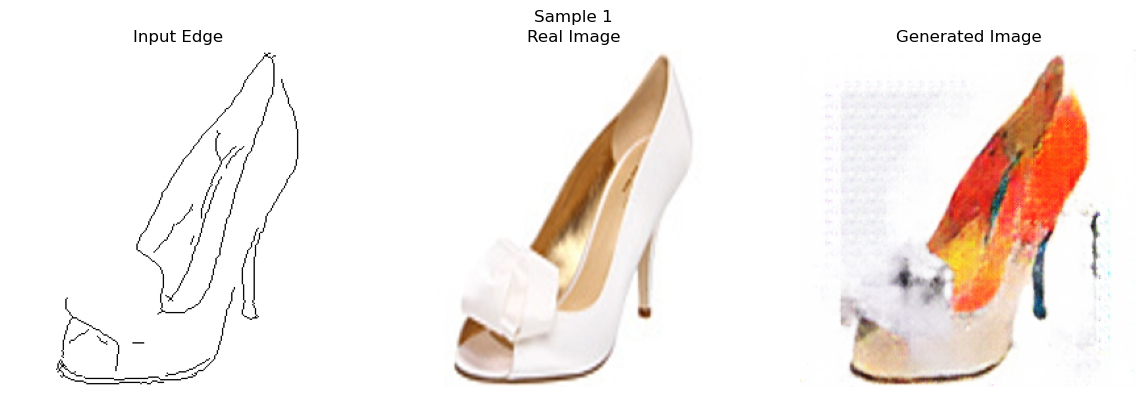

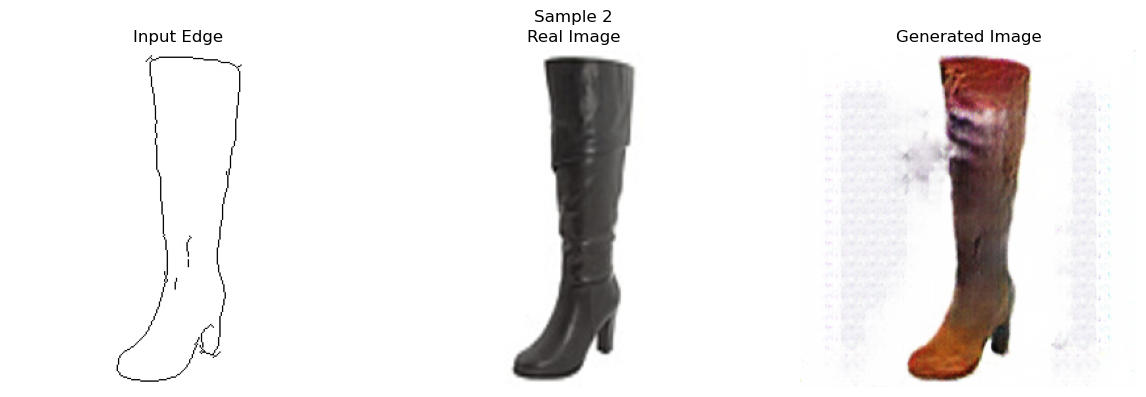

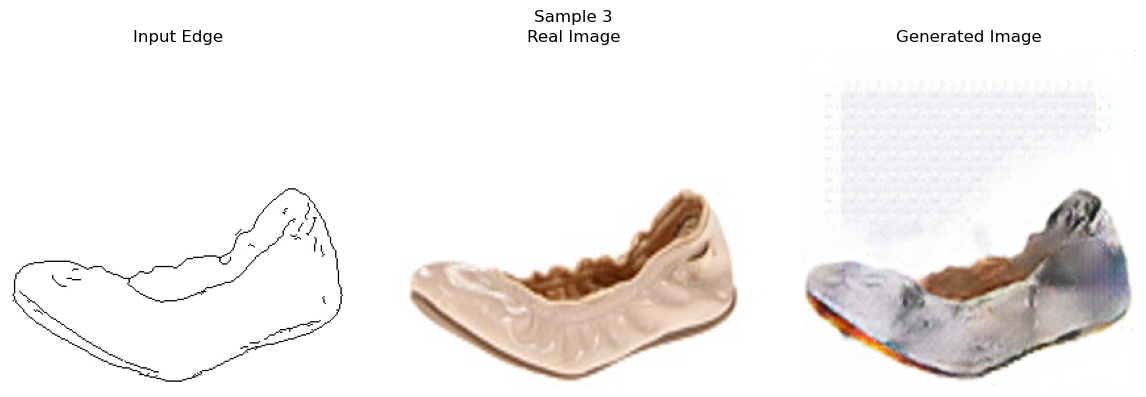


Model Performance Metrics:
PSNR: 19.1243
SSIM: 0.7641
LPIPS: 0.3154
FID: 217.9086

Baseline FID: 50.00
Improvement: ❌ (Current FID: 217.91)


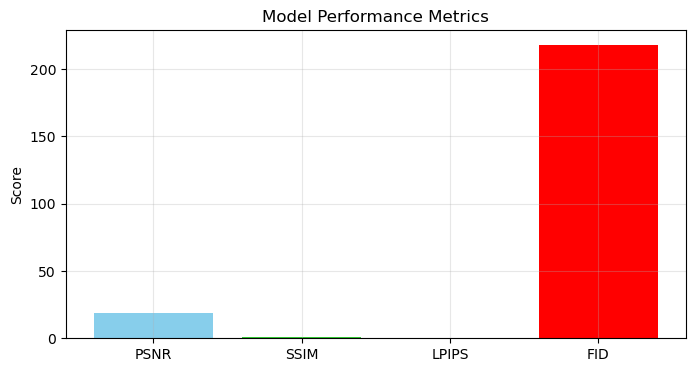

In [113]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.utils import make_grid
import torch.nn as nn
from scipy import linalg
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from lpips import LPIPS
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize LPIPS model
lpips_model = LPIPS(net='alex').to(device)

# ----- Metric Functions -----

def calculate_psnr(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1)
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1)
    return psnr(real_img.cpu().numpy(), gen_img.cpu().numpy(), data_range=1.0)

def calculate_ssim(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1)
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1)

    real_np = real_img.squeeze().permute(1, 2, 0).cpu().numpy()
    gen_np = gen_img.squeeze().permute(1, 2, 0).cpu().numpy()

    ssims = [ssim(real_np[..., i], gen_np[..., i], data_range=1.0, win_size=3)
             for i in range(real_np.shape[-1])]
    return np.mean(ssims)

def calculate_lpips(real_img, gen_img):
    real_img = (real_img * 0.5 + 0.5).clamp(0, 1) * 2 - 1
    gen_img = (gen_img * 0.5 + 0.5).clamp(0, 1) * 2 - 1
    return lpips_model(real_img, gen_img).item()

# ----- FID Calculation -----

def calculate_fid(real_imgs, gen_imgs):
    def get_features(imgs):
        model = inception_v3(pretrained=True, transform_input=False).to(device)
        model.eval()
        model.fc = nn.Identity()
        
        imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            features = model(imgs)
        return features.cpu().numpy()
    
    real_features = get_features(real_imgs)
    gen_features = get_features(gen_imgs)

    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

# ----- Evaluation Wrapper -----

def evaluate_model(generator, dataloader, num_samples=10, fid_baseline=None):
    psnr_values, ssim_values, lpips_values = [], [], []
    real_images, gen_images = [], []
    
    generator.eval()

    with torch.no_grad():
        for i, (edge, real) in enumerate(dataloader):
            if i >= num_samples:
                break

            edge, real = edge.to(device), real.to(device)
            generated = generator(edge)

            psnr_values.append(calculate_psnr(real, generated))
            ssim_values.append(calculate_ssim(real, generated))
            lpips_values.append(calculate_lpips(real, generated))

            real_images.append(real)
            gen_images.append(generated)

            # Show visual comparison (first few only)
            if i < 3:
                visualize_comparison(edge, real, generated, idx=i)

    real_images = torch.cat(real_images, dim=0)
    gen_images = torch.cat(gen_images, dim=0)

    try:
        fid_score = calculate_fid(real_images, gen_images)
    except Exception as e:
        print(f"FID calculation failed: {e}")
        fid_score = np.nan

    # Output results
    metrics = {
        'PSNR': np.mean(psnr_values),
        'SSIM': np.mean(ssim_values),
        'LPIPS': np.mean(lpips_values),
        'FID': fid_score
    }

    print("\nModel Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if not np.isnan(v) else f"{k}: NaN")

    # Compare FID if baseline provided
    if fid_baseline is not None:
        print(f"\nBaseline FID: {fid_baseline:.2f}")
        print(f"Improvement: {'✅' if fid_score < fid_baseline else '❌'} (Current FID: {fid_score:.2f})")

    # Plot metrics
    valid_metrics = {k: v for k, v in metrics.items() if not np.isnan(v)}
    plt.figure(figsize=(8, 4))
    plt.bar(valid_metrics.keys(), valid_metrics.values(),
            color=['skyblue', 'limegreen', 'orange', 'red'][:len(valid_metrics)])
    plt.title("Model Performance Metrics")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.show()

    return metrics

# ----- Visualization -----

def visualize_comparison(edge, real, generated, idx=0):
    def denorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1)

    edge = denorm(edge.squeeze(0).cpu())
    real = denorm(real.squeeze(0).cpu())
    generated = denorm(generated.squeeze(0).cpu())

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(edge.permute(1, 2, 0))
    axs[0].set_title('Input Edge')
    axs[1].imshow(real.permute(1, 2, 0))
    axs[1].set_title('Real Image')
    axs[2].imshow(generated.permute(1, 2, 0))
    axs[2].set_title('Generated Image')
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Sample {idx+1}')
    plt.tight_layout()
    plt.show()

# ----- Usage -----
# Run this after defining your `generator` model and `dataloader`

# Optional: set a known baseline FID to compare against
baseline_fid = 50.0  # example value

metrics = evaluate_model(generator, dataloader, num_samples=min(10, len(dataloader)), fid_baseline=baseline_fid)


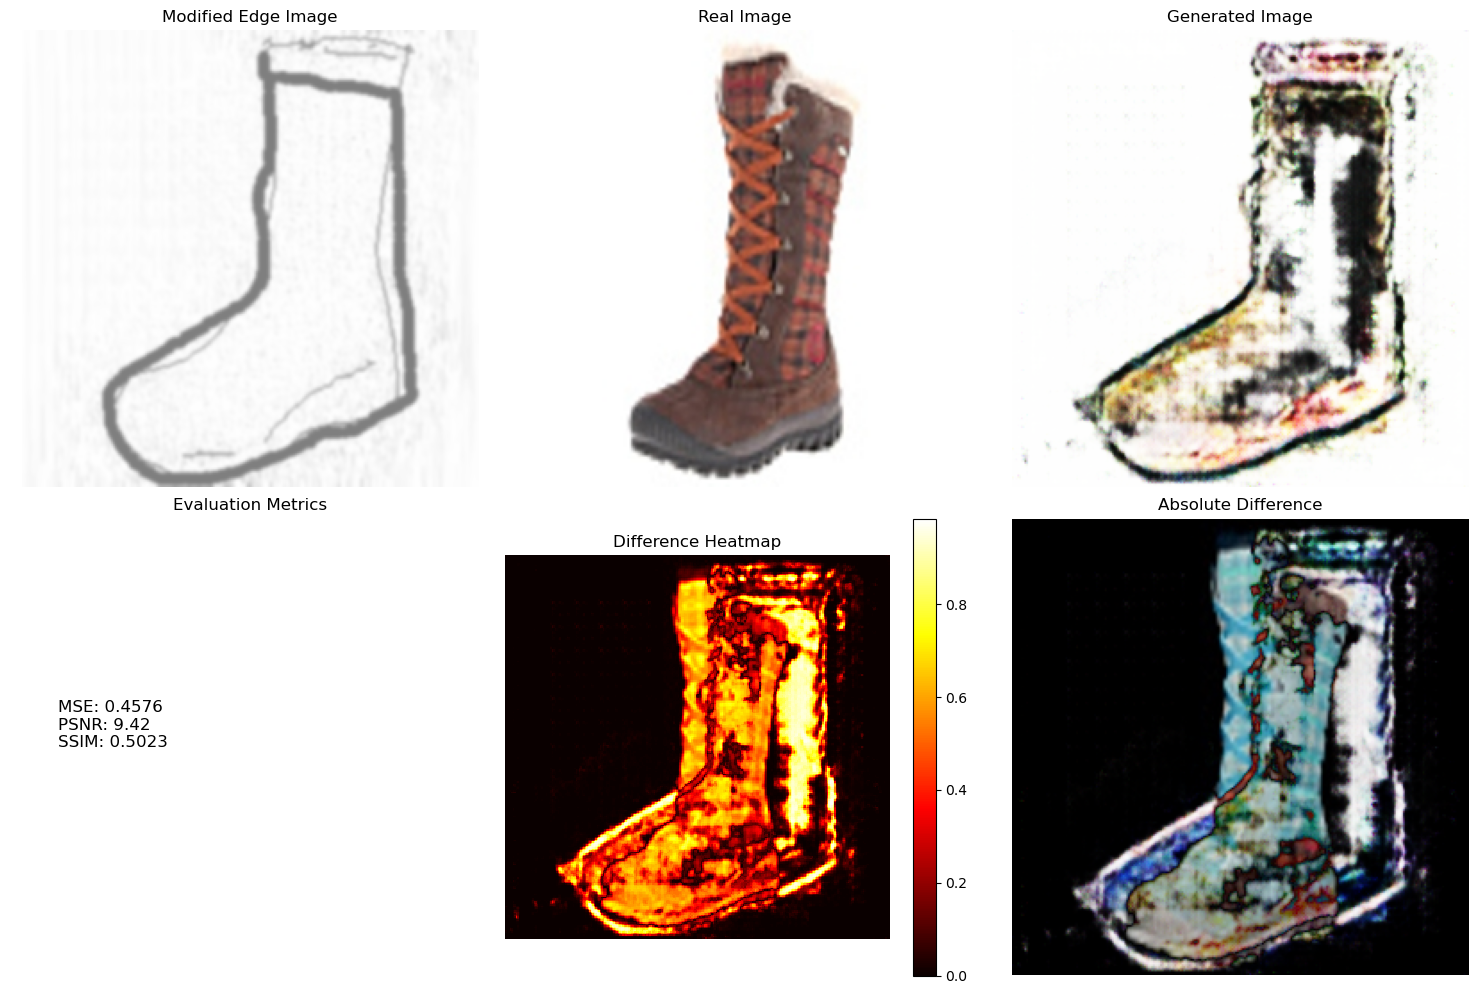

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# After generating the images
def compute_metrics(real_img, generated_img):
    """Compute evaluation metrics between real and generated images"""
    # Convert to numpy arrays in [0,1] range
    real_np = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    real_np = (real_np * 0.5 + 0.5).clip(0, 1)
    
    gen_np = generated_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    gen_np = (gen_np * 0.5 + 0.5).clip(0, 1)
    
    # Convert to grayscale for SSIM
    real_gray = np.mean(real_np, axis=2)
    gen_gray = np.mean(gen_np, axis=2)
    
    # Compute metrics
    mse = F.mse_loss(generated_img, real_img).item()
    psnr_val = psnr(real_np, gen_np, data_range=1.0)
    ssim_val = ssim(real_gray, gen_gray, data_range=1.0)
    
    return {
        'MSE': mse,
        'PSNR': psnr_val,
        'SSIM': ssim_val
    }

def compute_heatmap(real_img, generated_img):
    """Compute difference heatmap between real and generated images"""
    real_np = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    real_np = (real_np * 0.5 + 0.5).clip(0, 1)
    
    gen_np = generated_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    gen_np = (gen_np * 0.5 + 0.5).clip(0, 1)
    
    # Compute absolute difference
    diff = np.abs(real_np - gen_np)
    heatmap = np.mean(diff, axis=2)  # Average across channels
    
    return heatmap

# Visualization function
def visualize_comparison(real_img, edge_img, generated_img, metrics, heatmap):
    """Visualize the comparison between real, edge, and generated images"""
    # Convert tensors to display format
    real_disp = denormalize(real_img[0]).permute(1, 2, 0).cpu().numpy()
    edge_disp = denormalize(edge_img[0]).permute(1, 2, 0).cpu().numpy()
    gen_disp = denormalize(generated_img[0]).permute(1, 2, 0).cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot images
    plt.subplot(2, 3, 1)
    plt.imshow(edge_disp, cmap='gray')
    plt.title("Modified Edge Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(real_disp)
    plt.title("Real Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(gen_disp)
    plt.title("Generated Image")
    plt.axis('off')
    
    # Plot metrics
    plt.subplot(2, 3, 4)
    plt.text(0.1, 0.5, 
             f"MSE: {metrics['MSE']:.4f}\nPSNR: {metrics['PSNR']:.2f}\nSSIM: {metrics['SSIM']:.4f}",
             fontsize=12)
    plt.axis('off')
    plt.title("Evaluation Metrics")
    
    # Plot heatmap
    plt.subplot(2, 3, 5)
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Difference Heatmap")
    plt.axis('off')
    
    # Plot difference
    plt.subplot(2, 3, 6)
    diff_img = np.abs(real_disp - gen_disp)
    plt.imshow(diff_img)
    plt.title("Absolute Difference")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# After generating the image from modified edges
metrics = compute_metrics(real_image, generated_image)
heatmap = compute_heatmap(real_image, generated_image)

# Visualize the comparison
visualize_comparison(real_image, edge_modified, generated_image, metrics, heatmap)